In [39]:
# Imports as always...
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn.functional as F

import torchvision
from torchvision import transforms

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')

CUDA is available for use with PyTorch: True


# Deriving Continuous Hopfield Networks for MNIST Reconstruction and Classification

This is a reconstruction and walkthrough of the *Hopfield Networks are all you need* paper [(Ramsauer et al., 2020)](https://arxiv.org/pdf/2008.02217.pdf) and accompanying [blog post](https://ml-jku.github.io/hopfield-layers/). We also take from [this blog post](https://www.beren.io/2020-11-02-Walkthrough_Hopfield-Networks-Is-All-You-Need/), which excellently explains the derivation as per the paper.

In [3]:
# Getting the MNIST data.
def get_data(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Training data.
    train_dataset = torchvision.datasets.MNIST(
        root='./data/MNIST',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Testing data.
    test_dataset = torchvision.datasets.MNIST(
        root='./data/MNIST',
        train=False,
        download=True,
        transform=transform
    ) 
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    train_dataset = list(iter(train_loader))
    for i, (image, label) in enumerate(train_dataset):
        train_dataset[i] = (image.reshape(len(image), 784), label)
        
    test_dataset = list(iter(test_loader))
    for i, (image, label) in enumerate(test_dataset):
        test_dataset[i] = (image.reshape(len(image), 784), label)
        
    return train_dataset, test_dataset
        
# We aren't doing any training, but this batch size determines how many examples we can store.
train_dataset, test_dataset = get_data(batch_size=128)

Text(0.5, 1.0, 'Masked digit')

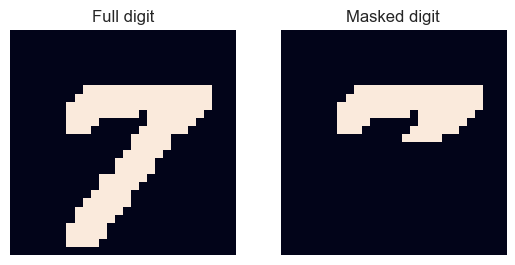

In [4]:
# Convert an images to binary [-1,1].
def image_to_binary(image):
    binary_image = deepcopy(image)
    
    binary_image[image <= 0] = -1
    binary_image[image >  0] =  1
    
    return binary_image

# Mask the bottom of an image.
def mask_image(image):
    masked_image = deepcopy(image)
    height, _ = image.shape
    
    masked_image[height // 2 : height, :] = -1
    return masked_image

# Get a random training batch.
images, label = train_dataset[np.random.randint(low=0, high=len(train_dataset))]

# Convert a random image to binary and mask the bottom half.
digit = images[np.random.randint(images.shape[0]), :].reshape(784, 1)
digit = image_to_binary(digit)
masked_digit = mask_image(digit.reshape(28, 28)).reshape(784, 1)

# Show them.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(digit.reshape(28, 28))
ax2.imshow(masked_digit.reshape(28, 28))

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')

ax1.set_title('Full digit')
ax2.set_title('Masked digit')

## The Classic Hopfield Network

Text(0.5, 1.0, 'Full digit')

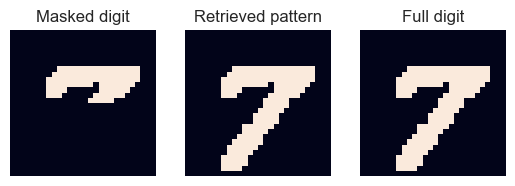

In [5]:
# Store a digit in the weights.
W = digit @ digit.T

# Perform the Hopfield update rule with a partial cue to be "retrieved".
out = image_to_binary(W @ masked_digit)

# Show them.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(masked_digit.reshape(28, 28))
ax2.imshow(out.reshape(28, 28))
ax3.imshow(digit.reshape(28, 28))

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')

ax1.set_title('Masked digit')
ax2.set_title('Retrieved pattern')
ax3.set_title('Full digit')

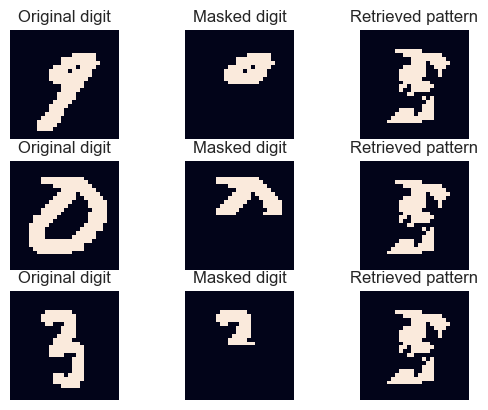

In [6]:
# Try storing and retrieving multiple patterns to demonstrate the storage capacity of the network.
def store_retrieve_n_images(images, n):
    # Pick n random indices for training examples.
    image_indices = np.random.choice(np.arange(images.shape[0]), size=n, replace=False)
    
    # Construct the weight matrix of the stored images.
    W = torch.zeros(size=(784, 784))
    for image_index in image_indices:
        digit = image_to_binary(images[image_index, :].reshape(784, 1))
        W += digit @ digit.T
    
    # Try to retrieve each image.
    fig, axes = plt.subplots(n, 3)
    for i, image_index in enumerate(image_indices):
        # Do the thing.
        digit = image_to_binary(images[image_index, :]).reshape(28, 28)
        masked_digit = mask_image(digit).reshape(784, 1)
        out = image_to_binary(W @ masked_digit)
        
        # Plot the thing.
        axes[i][0].imshow(digit)
        axes[i][1].imshow(masked_digit.reshape(28, 28))
        axes[i][2].imshow(out.reshape(28, 28))
        
        # Beautify the thing.
        axes[i][0].axis('off')
        axes[i][0].axis('tight')
        axes[i][0].axis('image')
        axes[i][1].axis('off')
        axes[i][1].axis('tight')
        axes[i][1].axis('image')
        axes[i][2].axis('off')
        axes[i][2].axis('tight')
        axes[i][2].axis('image')
        
        axes[i][0].set_title('Original digit')
        axes[i][1].set_title('Masked digit')
        axes[i][2].set_title('Retrieved pattern')
        
store_retrieve_n_images(images, 3)

## The Modern Hopfield Network

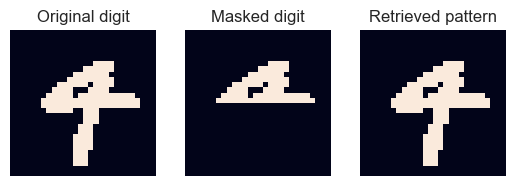

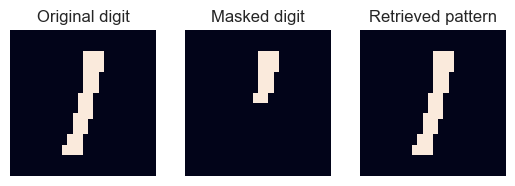

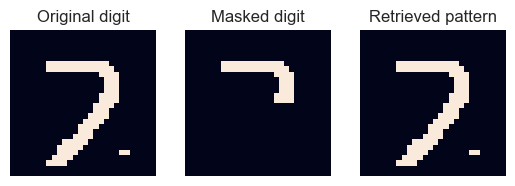

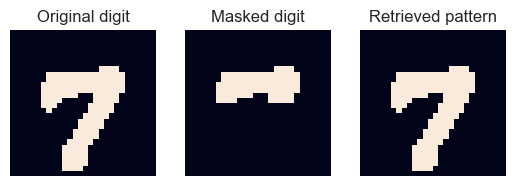

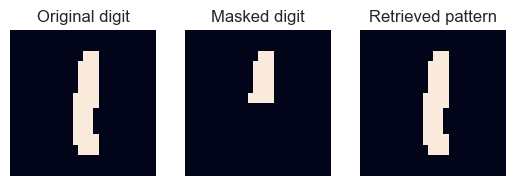

In [7]:
# Define the modern update rule proposed in Demircigil (2017).
def demircigil_update_rule(z, xs, arbitrary_divisor=10):
    out = torch.zeros(len(z), 1)
    
    # For each element of z...
    for i in range(len(z)):
        # Initialise variables to accumulate energy.
        E_pos, E_neg = 0, 0
        z_pos, z_neg = deepcopy(z), deepcopy(z)
        
        # Consider both a positive and negative single-edit changes to the partial cue.
        z_pos[i] =  1
        z_neg[i] = -1
        
        # For each stored pattern in xs...
        for x in xs:
            # Compute positive or negative energies.
            E_plus  = x.T @ z_pos
            E_minus = x.T @ z_neg
            
            # Accumulate their exponents.
            E_pos += torch.exp(E_plus  / arbitrary_divisor)
            E_neg += torch.exp(E_minus / arbitrary_divisor)
            
        # If the energy is greater, then flip.
        if E_pos > E_neg:
            out[i] =  1
        else:
            out[i] = -1
            
    return out
    
# Try storing and retrieving multiple patterns to demonstrate the storage capacity of the network when using the update rule due to Demircigil (2017).
def store_retrieve_demircigil_n_images(images, n, break_val=-1):
    # Pick n random training examples.
    image_indices = np.random.choice(np.arange(images.shape[0]), size=n, replace=False)
    xs = [image_to_binary(images[image_index, :].reshape(784, 1)) for image_index in image_indices]
    
    for i, image_index in enumerate(image_indices):
        # Making sure we don't print too much when n is very large.
        if break_val > 0:
            if i >= break_val:
                break
                
        # Do the thing.
        masked_digit = mask_image(xs[i]).reshape(784, 1)
        out = demircigil_update_rule(masked_digit, xs)
        
        # Plot the thing.
        fig, axes = plt.subplots(1, 3)
        plots = [xs[i], masked_digit, out]
        titles = ['Original digit', 'Masked digit', 'Retrieved pattern']
        for j, ax in enumerate(axes.flatten()):
            plt.sca(ax)
            plt.imshow(plots[j].reshape(28, 28))
            plt.title(titles[j])
            
            ax.axis('off')
            ax.axis('tight')
            ax.axis('image')
        
        plt.show()
        
store_retrieve_demircigil_n_images(images, 5, break_val=-1)

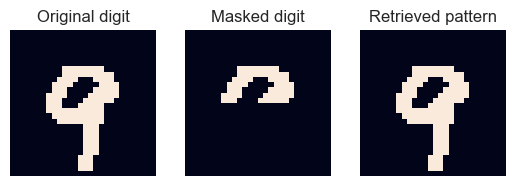

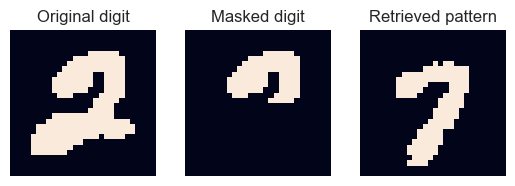

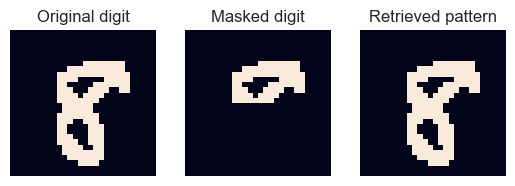

In [10]:
# An example of the much larger capacity.
store_retrieve_demircigil_n_images(images, 100, break_val=3)

## The Continuous Modern Hopfield Network

Text(0.5, 1.0, 'Masked digit')

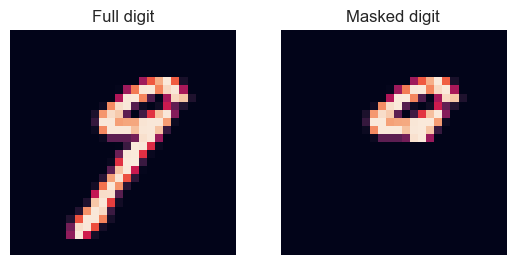

In [13]:
# Redefine the masking to be continuous.
def mask_continuous_digit(image):
    height, _ = image.reshape(28, 28).shape
    
    masked_image = deepcopy(image.reshape(28, 28))
    masked_image[height // 2 : height, :] = 0
    
    return masked_image

# Get a random digit and mask it.
digit = images[np.random.randint(images.shape[0]), :]
masked_digit = mask_continuous_digit(digit)

# Show them.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(digit.reshape(28, 28))
ax2.imshow(masked_digit)

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')

ax1.set_title('Full digit')
ax2.set_title('Masked digit')

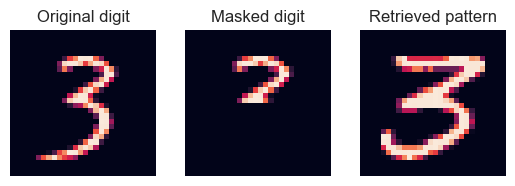

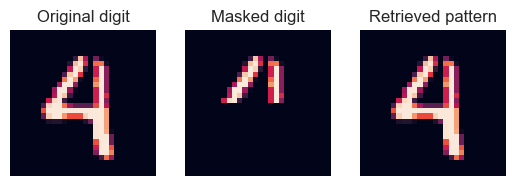

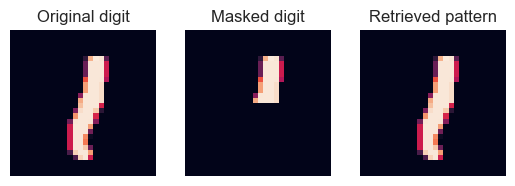

In [19]:
# Define the continuous update rule.
def continuous_update_rule(X, z, beta):
    return X.T @ F.softmax(beta * X @ z, dim=0)

# Try storing and retrieving multiple patterns to demonstrate the storage capacity of the network when using the continuous update rule.
def store_retrieve_continuous_n_images(images, n, beta=8, break_val=-1):
    # Pick n random training examples.
    image_indices = np.random.choice(np.arange(images.shape[0]), size=n, replace=False)
    X = images[image_indices, :]
    
    for i, image_index in enumerate(image_indices):
        # Making sure we don't print too much when n is very large.
        if break_val > 0:
            if i >= break_val:
                break
                
        # Do the thing.
        z = mask_continuous_digit(X[i, :]).reshape(784, 1)
        out = continuous_update_rule(X, z, beta)
        
        # Plot the thing.
        fig, axes = plt.subplots(1, 3)
        plots = [X[i, :], z, out]
        titles = ['Original digit', 'Masked digit', 'Retrieved pattern']
        for j, ax in enumerate(axes.flatten()):
            plt.sca(ax)
            plt.imshow(plots[j].reshape(28, 28))
            plt.title(titles[j])
            
            ax.axis('off')
            ax.axis('tight')
            ax.axis('image')
        
        plt.show()
        
store_retrieve_continuous_n_images(images, 100, break_val=3)

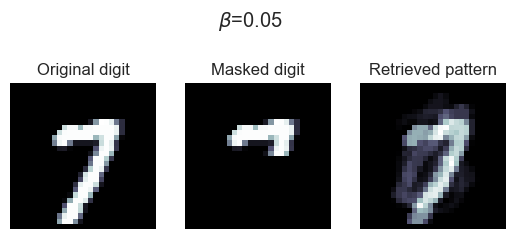

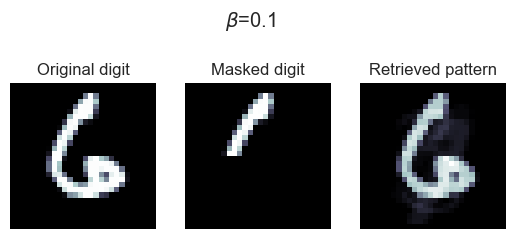

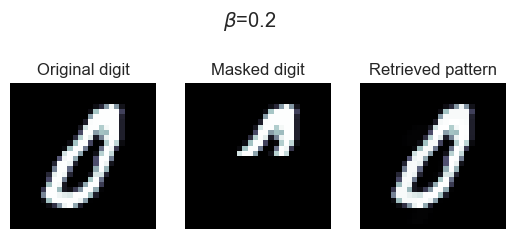

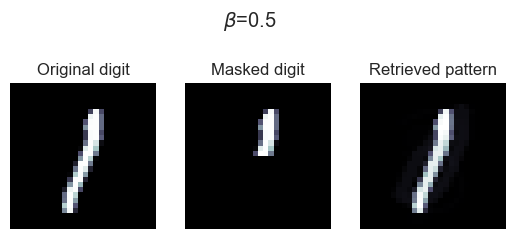

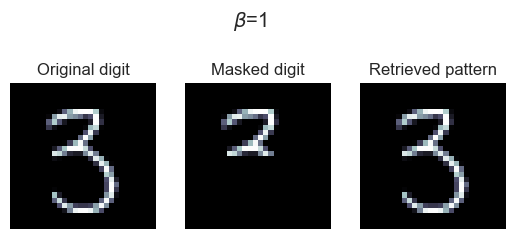

In [38]:
# Demonstrate the effect of the beta parameter.
betas = [.05, .1, .2, .5, 1]

image_indices = np.random.choice(np.arange(images.shape[0]), size=len(betas), replace=False)
X = images[image_indices, :]

for i, image_index in enumerate(image_indices):
    # Do the thing.
    z = mask_continuous_digit(X[i, :]).reshape(784, 1)
    out = continuous_update_rule(X, z, betas[i])
    
    # Plot the thing.
    fig, axes = plt.subplots(1, 3)
    plots = [X[i, :], z, out]
    titles = ['Original digit', 'Masked digit', 'Retrieved pattern']
    for j, ax in enumerate(axes.flatten()):
        plt.sca(ax)
        plt.imshow(plots[j].reshape(28, 28), cmap='bone')
        plt.title(titles[j])
        fig.suptitle(f'$\\beta$={betas[i]}', y=.8)
        
        ax.axis('off')
        ax.axis('tight')
        ax.axis('image')
    
    plt.show()